# PyMieDAP: a versatile radiative transfer model with polarization


## Introduction

### What is PyMieDAP?

**PyMieDAP** stands for Python Mie Doubling-Adding Program. It is basically a Python module which uses FORTRAN elements to compute Mie scattering and the Doubling-Adding method to perform radiative transfer calculations.

### What is it useful for?

**PyMieDAP** can be used to model planetary atmospheres with gaz but also with aerosols and clouds. It will allow you to define the structure of your atmosphere and some properties of your planet to compute the full Stokes vector of the outcoming light reflected and scattered by the planet.

## Installing

### Dependencies

**PyMieDAP** requires that you have the following installed on your computer:

* Python 2.7 or higher (PyMieDAP should be compatible with both 2.7 and 3.x versions of Python)
* Scipy and Numpy libraries for Python
* f2py (should normally come with numpy)
* matplotlib for the graphics: plotting things and such.

### Installation procedure

#### Installing

To install, you can use the setup.py script

```python
python setup.py install
```

this will install PyMieDAP where python itself is installed. If you want to
install it in your home folder, you can use

```python
python setup.py install --home=~

```
If you install it locally, you'll need to add ~/lib/python (or the path you
chose) to your PYTHONPATH.
Add this to your .bashrc

```bash
export PYTHONPATH=$PYTHONPATH:~/lib/python
```
then run the install.

Be careful that on Mac, you might need to use another file than .bashrc. Also, for **Spyder** users, you can set it with Spyder's PYTHONPATH manager.

Once installed and your path set correctly, you can import PyMieDAP and Exopy in a
(i)Python terminal or a script.

To know more about how to use PyMieDAP, you can refer to this notebook or to the
script 'pymiedap_demo.py'.

You should now be able to continue.


In [1]:
%matplotlib inline

## Getting started

You can use PyMieDAP in a python script or interactively in a shell (Python or IPython, we recommend the latter). For the rest of the examples, we will use a shell.

To import PyMieDAP, just run


In [2]:
import pymiedap.pymiedap as pmd

this will import the main module under the alias `pmd`. This is our convention, but you can use another alias. From now on, you can call all the classes and functions of PyMieDAP by using this alias.

In [3]:
import matplotlib.pyplot as mpl  # for plotting

In [4]:
import numpy as np 

## General principles

### The big picture

This figure gives you an overview of the components of PyMieDAP and how they work together.
![PyMieDAP diagram](/pymiedap_diagramm.pdf)

### The Model class

Most of the PyMieDAP revolves around the `Model` class. This class contains (nearly) all the information about the planet, the atmosphere and the aerosols contained in it.

You can create a model by using:

In [5]:
model = pmd.Model()

Then you can access the content of the model with the following pattern:

`model.thing`

Where `thing` is an attribute of the class.

The general inputs of the model class are:

* general settings
   * `wvl_list` : list of wavelengths (in microns) to compute. Each time the list is changed (all at once) the others properties that depend on the wavelength within the layers are updated.
* For the star
   * `Ts`: temperature of the star in K
   * `Rs`: Radius of the star in meters
   * `Dps`: distance planet-star in meters
* For the planet
   * `gravity`: value of the acceleration of gravity (in m/s^2)
   * `surface`: a 4x4 array describing a constant reflection matrix. Then the Lambertian albedo is `surface[0,0]`. _or_ 
       a filename with the Fourier coefficients of a more complicated surface. 
* For the atmosphere
   * `mma`: molecular mass of the gas (in atomic mass units)
   * `dpol`: depolarisation factor for the gas medium
   * `Layers`: a Layer class object containing several Layer objects (see below)
   * `set_rindex_gas`: a method that computes the refractive index of the gas. Important when it comes to the computation of the molecular scattering cross-section. 

The class also contains outputs we will describe later

* `fcloud`: cloud cover when doing resolved and integrated simulations
* `asym`: asymmetry in cloud cover
* `picture`: image of cloud cover
* `I`, `Q`, `U`, `V`: Stokes vectors
* `P` : degree of linear polarization (-Q/I)


If you don't remember exactly what your model looks like, you can have some basic information summarised just by typing the name of the model in your IPython session; then information like this will appear:

In [6]:
model # only for IPython, in a script `print(model)` will also work

Model:


**Operating wavelengths:
[1.101] microns

**Planet data:**
 g=9.81 m/s^2; surf.alb.=0.00
 
**Gas data**
 mma=44.00 dpol=0.09

 **Layers** 
LAYER gasbelow
 Type:C, P=100, tau=[0.0], tau_gas=[0.0]
Spherical particles
nr =[1.42, 1.41]))
ni =[1e-08, 1e-08]))
   R_eff = 1.050 
 Type: C
LAYER gastop
 Type:C, P=1e-05, tau=[0.0], tau_gas=[0.0]
Spherical particles
nr =[1.42, 1.41]))
ni =[1e-08, 1e-08]))
   R_eff = 1.050 
 Type: C
LAYER cloud
 Type:C, P=1.0, tau=[30], tau_gas=[0.0]
Spherical particles
nr =[1.42, 1.41]))
ni =[1e-08, 1e-08]))
   R_eff = 1.050 
 Type: C
LAYER haze
 Type:C, P=0.01, tau=[0.01], tau_gas=[0.0]
Spherical particles
nr =[1.42, 1.41]))
ni =[1e-08, 1e-08]))
   R_eff = 1.050 
 Type: C

As seen the model contains informations about the star and the planet. But to describe in more details the atmosphere, we need to look at the `Layer` class.

### The Layer class

The model has an attribute `Layers` that does nothing special except containing the atmospheric layers. Each layer is described by its own instance of the `Layer` class.

The layer class as the following inputs:

* `tau` : optical thickness **for aerosols** of the layer (an array, so that `tau` is defined for each wavelength)
* `tau_g` : optical thickness related to **gaseous absorption** (for each lambda)
* `press` : pressure at the bottom of the layer, in bars.
* `rayscat`: if True, the opacity due to Rayleigh scattering is automatically computed based on the difference of pressure between the top and bottom of the layer and the molecular mass. If False, the value used is the user-defined `tau_ray`.
* `tau_ray`: user defined optical thickness due to **Rayleigh scattering** (for each wvl)
* `aerosols` : an object containing the properties of a type of aerosols.
* `col_dens` : the particular column density of the layer (in part.$\mu m^{-2}$)

_Note_: this latter variable is wavelength independent and can be used to set realistic values of the opacities as we'll see later.

To add a layer, you can simply do:

In [7]:
model.layers.mynewlayer = pmd.Layer()

In [8]:
print(model)

Model:
**Operating wavelengths:
[1.101] microns

**Planet data:**
 g=9.81 m/s^2; surf.alb.=0.00
 
**Gas data**
 mma=44.00 dpol=0.09

 **Layers** 
LAYER mynewlayer
 Type:C, P=0.03, tau=[30], tau_gas=[0.0]
Spherical particles
nr =[1.42, 1.41]))
ni =[1e-08, 1e-08]))
   R_eff = 1.050 
 Type: C
LAYER gasbelow
 Type:C, P=100, tau=[0.0], tau_gas=[0.0]
Spherical particles
nr =[1.42, 1.41]))
ni =[1e-08, 1e-08]))
   R_eff = 1.050 
 Type: C
LAYER gastop
 Type:C, P=1e-05, tau=[0.0], tau_gas=[0.0]
Spherical particles
nr =[1.42, 1.41]))
ni =[1e-08, 1e-08]))
   R_eff = 1.050 
 Type: C
LAYER cloud
 Type:C, P=1.0, tau=[30], tau_gas=[0.0]
Spherical particles
nr =[1.42, 1.41]))
ni =[1e-08, 1e-08]))
   R_eff = 1.050 
 Type: C
LAYER haze
 Type:C, P=0.01, tau=[0.01], tau_gas=[0.0]
Spherical particles
nr =[1.42, 1.41]))
ni =[1e-08, 1e-08]))
   R_eff = 1.050 
 Type: C



Note that the new layer is now visible in the list of layers. You can also set values for the layer when you call initiate it, so you could also do things like:

In [9]:
model.layers.mynewlayer = pmd.Layer(tau=[0.5], press=0.3)

In [10]:
model

Model:


**Operating wavelengths:
[1.101] microns

**Planet data:**
 g=9.81 m/s^2; surf.alb.=0.00
 
**Gas data**
 mma=44.00 dpol=0.09

 **Layers** 
LAYER mynewlayer
 Type:C, P=0.3, tau=[0.5], tau_gas=[0.0]
Spherical particles
nr =[1.42, 1.41]))
ni =[1e-08, 1e-08]))
   R_eff = 1.050 
 Type: C
LAYER gasbelow
 Type:C, P=100, tau=[0.0], tau_gas=[0.0]
Spherical particles
nr =[1.42, 1.41]))
ni =[1e-08, 1e-08]))
   R_eff = 1.050 
 Type: C
LAYER gastop
 Type:C, P=1e-05, tau=[0.0], tau_gas=[0.0]
Spherical particles
nr =[1.42, 1.41]))
ni =[1e-08, 1e-08]))
   R_eff = 1.050 
 Type: C
LAYER cloud
 Type:C, P=1.0, tau=[30], tau_gas=[0.0]
Spherical particles
nr =[1.42, 1.41]))
ni =[1e-08, 1e-08]))
   R_eff = 1.050 
 Type: C
LAYER haze
 Type:C, P=0.01, tau=[0.01], tau_gas=[0.0]
Spherical particles
nr =[1.42, 1.41]))
ni =[1e-08, 1e-08]))
   R_eff = 1.050 
 Type: C

You can also delete a layer

In [11]:
del(model.layers.mynewlayer)

In [12]:
model

Model:


**Operating wavelengths:
[1.101] microns

**Planet data:**
 g=9.81 m/s^2; surf.alb.=0.00
 
**Gas data**
 mma=44.00 dpol=0.09

 **Layers** 
LAYER gasbelow
 Type:C, P=100, tau=[0.0], tau_gas=[0.0]
Spherical particles
nr =[1.42, 1.41]))
ni =[1e-08, 1e-08]))
   R_eff = 1.050 
 Type: C
LAYER gastop
 Type:C, P=1e-05, tau=[0.0], tau_gas=[0.0]
Spherical particles
nr =[1.42, 1.41]))
ni =[1e-08, 1e-08]))
   R_eff = 1.050 
 Type: C
LAYER cloud
 Type:C, P=1.0, tau=[30], tau_gas=[0.0]
Spherical particles
nr =[1.42, 1.41]))
ni =[1e-08, 1e-08]))
   R_eff = 1.050 
 Type: C
LAYER haze
 Type:C, P=0.01, tau=[0.01], tau_gas=[0.0]
Spherical particles
nr =[1.42, 1.41]))
ni =[1e-08, 1e-08]))
   R_eff = 1.050 
 Type: C

and the layer `mynewlayer` is gone.

### The Aerosols class

The `Layer` class does also contain `Aerosols` objects. These objects describe the type(s) of aerosol(s) that can exist in the layer.

These are the attributes of aerosols, first the inputs:

* `r_eff`, `v_eff` : effective radius and variance (constant with lambda)
* `nr`, `ni` : real, imaginary parts of refractive index (arrays for each wvl)
* `psd` : type of particle size distribution function. '2' stands for modified gamma. See inline doc for other distributions.
* `typ` : string indicating type of aerosols ex:'C' for clouds, 'H' for hazes; just for user's reference, doesn't change the results in any way

Note that PyMieDAP can compute Mie scattering for homogeneous spheres, but it can also compute calculations for layered spheres. Which brings us to other inputs:

* `layered`: if True, the calculation is made with Mie scattering for layered sphere (see Bohren and Huffmann, 1983)
* `nr_core`, `ni_core` : real, imaginary parts of refractive index for the inner core in case of layered spheres (for each wvl)
* `rcoremant`: ratio between the radius of the outer sphere and the inner core; only relevant for layered spheres. Obviously has to be between 0 and 1.

In the case of layered spheres, the outer part of the sphere is defined by the parameters `r_eff`, `nr`, `ni` described above.

After Mie calculations, you can get some output information:

* `qext` : extinction coefficients (for each wvl)
* `sext` : extinction cross-section (for each wvl)
* `qsca` : scattering coefficients (for each wvl)
* `ssca` : scattering cross-section (for each wvl)
* `ssalb` : aerosol single scattering albedo (for each wvl)
* `coefs`: array containing the expansion corefficients from the single scattering (cf. de Rooij et al. 1984). For the combined aerosols and for each wvl.

You might want to mix several types of aerosols in your layer. You can add a new type by doing:

In [13]:
model.layers.cloud.dust = pmd.Aerosols()

As for the layer, some parameters can be set when initialising the instance. (See the Aerosols docstring for available options)

In [14]:
model.layers.cloud.droplet = pmd.Aerosols(typ='D', r_eff=0.75)

Once you have several types of aerosols, you can defined their relative contribution by using the variable `f`:

* `f`: is the mix ratio of this type of aerosol in the layer. If `f=0.5`, half the opacity in the layer is due to this type.

In [15]:
model.layers.cloud.droplet.f = 0.75  # this type of aerosol makes 75% of the opacity in the layer `cloud`

Then when Mie scattering is computed, the layers are automatically mixed and the expansion coefficients are combined according to the relative contribution to the total opacity. A new aerosols object named `mixed_aerosols` is created in the layer. If you want to change one type of aerosols, always use the original instance and do not modify the `mixed_aerosols`. Note that the values of `f` are normalised in the operation. So if you put `f = 1` for one type and `f = 3` for the other, the values will become `f=0.25` and `f=0.75` respectively.

As for the model, typing the name of an aerosol type in the shell will prompt some information:

In [16]:
model.layers.cloud.droplet #an homogeneous sphere

Spherical particles
nr =[1.42, 1.41]))
ni =[1e-08, 1e-08]))
   R_eff = 0.750 
 Type: D

In [17]:
model.layers.cloud.dust.layered = True # a layered sphere

In [18]:
model.layers.cloud.dust

Layered spherical particles
nr_core =[1.42, 1.41] )) nr_mantle = [1.42, 1.41]))
ni_core =[1e-08, 1e-08] )) ni_mantle = [1e-08, 1e-08]))
   R_eff = 1.050 
   R core/mantle = 0.100 
 Type: C

Note: the type of the mixed aerosols will be the combined strings used to describe them. So if your first type is labeled 'C' and the second is labeled 'H', the mix will have `typ='CH'`.

## Computing the radiative transfer

We now want to compute the outcoming light from the model we defined. But first, let's see how this is done in detailed steps. Assuming we described an atmosphere and want to know what is the Stokes vector of the outgoing radiation for a list of observed geometries, here is the pipeline:

1. The Mie scattering code is called:
   * The single scattering phase function of each aerosol type in each layer is calculated by Mie scattering for each wavelength;
   * The phase function is expanded in generalized spherical harmonics, the so called expansion coefficients;
   * The coefficients are stored in the Aerosol object;
   * The coefficients of all types of aerosols in each layer are combined 
2. The Doubling-Adding code is called
   * For each wavelength, the Doubling-Adding method is applied for the layers
   * The reflectance matrix of the atmosphere is expanded in Fourier coefficients
   * Those coefficients are stored in a file. Note that this file contains the description of the scattering by the atmosphere from all possible geometries.
3. The actual Stokes vector is read
   * the output file of the DAP code is read
   * the Stokes vector is computed for all the desired geometries
   * the Stokes vector is returned, for all demanded wavelengths and geometries.

This could be done by several functions separately. Let's start afresh and split this in individual steps, from scratch. First, let's make a clean model.

In [19]:
del model

model = pmd.Model()

del model.layers.gasbelow

del model.layers.gastop

In [20]:
model.layers.cloud.dust = pmd.Aerosols(layered=True)

* `pmd.mie_code` computes the Mie scattering phase function of a given `Aerosols` object, for a given list of wavelengths

In [21]:
pmd.mie_code(model.layers.cloud.aerosols, [0.550])

Beginning of Mie program
Wavelength 0.5500000
End of Mie program


In [22]:
pmd.mie_code(model.layers.haze.aerosols, [0.550])

Beginning of Mie program
Wavelength 0.5500000
End of Mie program


* `pmd.mie_shell` is the same as `pmd.mie_code` but for layered spheres.

In [23]:
pmd.mie_shell(model.layers.cloud.dust, [0.550])

Beginning of Mie program
Wavelength 00.550
End of Mie program


Now, let's mix the aerosols in the layers

In [24]:
model.layers.cloud.mix_aerosols()

Aerosols mixed!


In [25]:
model.layers.haze.mix_aerosols()

Aerosols mixed!


* `pmd.dap_code` does the doubling-adding for a given model

In [26]:
pmd.dap_code(model)

Beginning of DAP program
Wavelength 1.1010000 microns
CC.sc.1.1010000
C.sc.1.1010000
fou_1.1010000.dat
End of DAP program


In this case, the output Fourier file is called `fou_1.1010000.dat`. We can also use an argument called rename with an output name.

In [27]:
pmd.dap_code(model, rename=True, output_name='testing')

Beginning of DAP program
Wavelength 1.1010000 microns
CC.sc.1.1010000
C.sc.1.1010000
fou_1.1010000.dat
End of DAP program


In this case, the output Fourier file is called `testing_1.1010000.dat`. So you can customize your file names so you can find you way through all your tests.

But instead of doing this yourself, there is a nice function that does it all for you! It's simply called `compute_model`.

In [28]:
pmd.compute_model(model, force=True)

In layer cloud:
Beginning of Mie program
Wavelength 1.1010000
End of Mie program
Beginning of Mie program
Wavelength 01.101
End of Mie program
Aerosols mixed!
In layer haze:
Beginning of Mie program
Wavelength 1.1010000
End of Mie program
Aerosols mixed!
Beginning of DAP program
Wavelength 1.1010000 microns
CC.sc.1.1010000
C.sc.1.1010000
fou_1.1010000.dat
End of DAP program


Much faster, isn't it? Now let's read the result.

* `pmd.read_dap_output` reads a DAP output file for a list of geometries (phase, sza and emission) and a filename of a Fourier file. It then returns Stokes elements `I`, `Q`, `U` and `V` for the given geometries.

In [29]:
phases = np.array([10., 0.]) #just defining two points

sza = np.array([9.9, 0.])

emission = np.array([0.1, 0.1])

In [30]:
I,Q,U,V = pmd.read_dap_output(phases,sza,emission, './dap_database/testing_1.1010000.dat')

/home/loic/Bureau/pymiedap/pymiedap/pymiedap.py:810: RuntimeWarning: divide by zero encountered in true_divide
  c_delta_phi = t1/t2
/home/loic/Bureau/pymiedap/pymiedap/pymiedap.py:853: RuntimeWarning: divide by zero encountered in true_divide
  cb = num/denom


In [31]:
print(I,Q,U,V)

[0.31587357 0.3193608 ] [-4.88465865e-03  3.72595216e-07] [1.83562046e-09 4.56297538e-23] [0. 0.]


Note that the shape is (number of wavelength, number of geometries).



_Note_ before going further, you should know that you can have more details for any function described above or in this whole tutorial by looking at the documentation by using:

In [32]:
help(pmd.mie_code)  # or pmd.mie_code? in IPython

Help on function mie_code in module pymiedap.pymiedap:

mie_code(aerosols, wavelengths, output=False, delta=1e-08, cutoff=1e-08, thmin=0, thmax=180, nsubr=50, ngaur=60, ncoefsMAX=4001, nfouMAX=4001, nmuMAX=201, nmatMAX=4)
    Compute Mie expansion coefficients for Aerosol object.
    Requires the module_mie module.
    
    Parameters
    ----------
    aerosols : Aerosol object
        an input aerosol type model containing all the modeling parameters
    wavelengths : array
        list of wavelengths for which computations should be performed
    delta: float, optional
        truncation of the Mie sum. Default 1e-8
    cutoff: float, optional
        cutoff value for the particle size distribution. Default 1e-8
    thmin: float, optional
        minimal value of phase angle (in degrees). Default 0
    thmax: float, optional
        maximal phase angle. Default 180.
    nsubr: integer, optional
        number of subintervals for the distribution. Default 50
    ngaur: integer, optio

## The data class

We shall introduce quickly the other module that comes within PyMieDAP, namely `data_class`. This class can be used with some observational data and its biggest interest is that it can contain geometrical information. This is what we will focus on here. For the rest, please read the inline documentation.

### Geometrical information

`data_class` can be used like this:

In [33]:
import pymiedap.data_class as dt

In [34]:
data = dt.Data()

The object data contains interesting attributes:

* `phase` is the phase angle of observations
* `geo` is an object containing much more details
   * `date`: date of observation
   * `time`: timestamp of each point
   * `time_str`: timestamp string of each point
   * `L_sun`: solar longitude
   * `Lat_sc`: spacecraft latitude
   * `Lon_sc`: spacecraft longitude
   * `Lat`: Latitude of obs point on planet
   * `Lon`: longitude
   * `Alt_sc`: altitude of spacecraft
   * `H`: altitude of the closest point of the LOS to the surface. Used for stellar occultations. Should be negative in nadir (LOS goes in the planet).
   * `phase`: phase angle
   * `sza`: solar zenith angle
   * `emission`: emission angle
   * `local_time`: local time of obs pt
   * `S_Mdist`: distance btw Sun and center of planet
   * `target_dist`: distance to the targeted point on the planet
   * `alt_topo`: topographic altitude

most of these are useful just for data handling (and come from SPICAV data information style), but the phase, sza and emission vectors are useful for PyMieDAP.

You can put the desired geometry you want in this object. Then use this data object with the function described afterwards.

_note_ : for convienience, and for quick model testing, a convienience function exists that will create a fake data object filled as a nadir observation.

In [35]:
data = dt.fake_data()

## read_model

The function you'll probably use often is `pmd.read_model`. This function takes a `Model` object and a `Data` object along with other options.

The inputs are:

* `model` : a Model object with all the input parameters
* `data` : a Data object with the observations But you can also use additional keywords:
* `step` : step between two data points used for the computations.
    This is important in case you have a large dataset. You might then want to skip points to save time.

* `force` : if `False`, existing Fourier files are not overwritten; if `True` existing files are replaced by newer versions
* `path_input` : path of the fourier DAP files.
    You can define a path where you store all your Fourier files, or just leave the default. If the folder indicated
    does not exist, it is created. Note also, that this is the folder used for the default input of the read_dap_output
    and default output for the dap_code

* `set_taus`: if True, will set opacities following scattering cross section and column density
* `output_name`: custom name radical for the output files of the DAP code. If not set, the files are named on the pattern `fou_wavelength.dat`.
* `rename`: if True, output_name is used to name files like `outputname_wavelength.dat`
* `nmug_mie`: number of Gauss points for Mie calculations
* `nmug`: number of Gauss points for DAP calculations
* `nmat`: number of Stokes elements to compute. Can be 1 if you just want I, 3 if you want I, Q and U, 4 for the full Stokes vector. This can also save time on heavy calculations.

To use this, you can simply do

In [36]:
model = pmd.Model() # starting with a fresh model
model.wvl_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] #setting new wavelengths

In [37]:
pmd.read_model(model,data, step=1)

In layer gasbelow:
Beginning of Mie program
Wavelength 0.3000000
Wavelength 0.4000000
Wavelength 0.5000000
Wavelength 0.6000000
Wavelength 0.7000000
Wavelength 0.8000000
Wavelength 0.9000000
Wavelength 1.0000000
End of Mie program
Aerosols mixed!
In layer gastop:
Beginning of Mie program
Wavelength 0.3000000
Wavelength 0.4000000
Wavelength 0.5000000
Wavelength 0.6000000
Wavelength 0.7000000
Wavelength 0.8000000
Wavelength 0.9000000
Wavelength 1.0000000
End of Mie program
Aerosols mixed!
In layer cloud:
Beginning of Mie program
Wavelength 0.3000000
Wavelength 0.4000000
Wavelength 0.5000000
Wavelength 0.6000000
Wavelength 0.7000000
Wavelength 0.8000000
Wavelength 0.9000000
Wavelength 1.0000000
End of Mie program
Aerosols mixed!
In layer haze:
Beginning of Mie program
Wavelength 0.3000000
Wavelength 0.4000000
Wavelength 0.5000000
Wavelength 0.6000000
Wavelength 0.7000000
Wavelength 0.8000000
Wavelength 0.9000000
Wavelength 1.0000000
End of Mie program
Aerosols mixed!
Beginning of DAP prog

As you see PyMieDAP will do all the necessary as described above. Do be afraid if this takes some time.

### The output

Once the computation is done, you'll see that the the attributes in the Model instance have been updated. In particular the attributes `model.I`, `model.P`, `model.Q`, `model.U` and `model.V` which are now arrays. Each of these has now the shape (number of wavelengths, number of geometries). The `model.geom` are also updated with the geometry used in the `Data` object, so you can plot the polarization not only as a function of phase angle but also as a function of solar zenith angle, emission angle or others if defined.

In [38]:
model.I.shape

(8, 899)

So, for example `model.P[0,:]` will give you all values of -Q/I for the first wavelength. Inversely, `model.P[:,0]` will give the degree of linear polarization at the first geometry defined, but for the whole range of input wavelengths.

You can now plot those elements at your will with python.

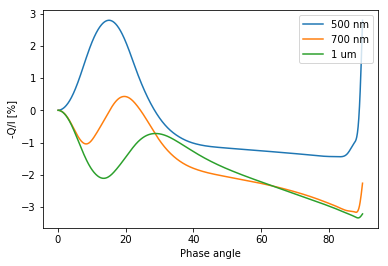

In [39]:
mpl.plot(model.phase,100 * model.P[2,:], label='500 nm') #plotting a phase curve at 500 nm
mpl.plot(model.phase,100 * model.P[4,:], label='700 nm') #plotting a phase curve at 700 nm
mpl.plot(model.phase,100 * model.P[-1,:], label='1 um') #plotting a phase curve at 1 um
mpl.xlabel('Phase angle')
mpl.ylabel('-Q/I [%]')
mpl.legend(loc='upper right')

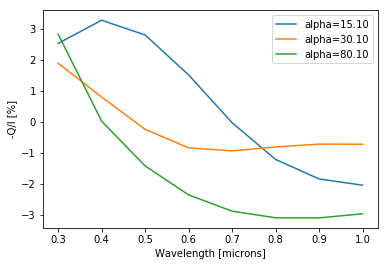

In [40]:
mpl.plot(model.wvl_list,100 * model.P[:,150], label='alpha={:2.2f}'.format(model.phase[150])) #plotting a spectrum
mpl.plot(model.wvl_list,100 * model.P[:,300], label='alpha={:2.2f}'.format(model.phase[300])) #plotting a spectrum
mpl.plot(model.wvl_list,100 * model.P[:,800], label='alpha={:2.2f}'.format(model.phase[800])) #plotting a spectrum
mpl.xlabel('Wavelength [microns]')
mpl.ylabel('-Q/I [%]')
mpl.legend()

## Going further

### Disk resolved cases

The calculations mentioned above are fine if you want a single-beam approach. But if you want to see what the planet would actually look like, you'll need `pmd.planet_pixels`.

This function will take a model and compute the Stokes elements of a planet seen with pixels as a function of phase angle and wavelength. Let's dive in the arguments.

* `atm_models`: a list of models to use
* `alpha`: phase angles, a vector
* `npix`: number of pixels (total number of pixels will be npix^2)
* `force`: if `True`, will force recalculation of model, even if DAP files already exist.
* `set_taus`: if `True`, will set opacities following scattering cross section and column density
* `rename`: if `True`, model output files will be renamed
* `output_name`: output name used for the DAP files if rename=True (see read_model doc)
* `fixed_pattern` : if True, a cloud pattern is generated at start and then reused for all phase angle after.
* `input_pattern` : an existing pattern that can be used as a starter (caution: must have size nphase * npix * npix)
* `nmug`: number of Gauss point for Mie and DAP codes
* `nmat`: number of Stokes elements to compute

* `cusp`: if `True`, polar cusps are created
* `thresh_lat`: defines the latitude above which the cusps exist
* `patchy`: if `True`, patchy clouds are generated
* `bands`: if `True`, latitudinal bands are generated
* `fcloud`: fraction of the planet to be covered with clouds
* `constant_fcloud`: if `True`, the factor fcloud applies not to the whole planet but to the lit part of the planet
* `sscloud`: if `True`, a subsolar cloud is created
* `sigma_c`: extend in degrees of the subsolar cloud with respect to the SSP. Cloud exists for SZA<sigma_c
* `delta_c`: offset in degrees the position of the subsolar cloud with respect to subsolar point.
* `bands_lats`: an array defining the boundaries of the bands. Should start at -90 and end at +90.
* `adaptive_pixels`: if `True`, npix increases with increasing phase angle (in sin^2 of alpha/2)
* `pixscaler`: factor used in combination with adaptive_pixels to set the rate of increase in pix number
* `xscale`: for patchy clouds gives the typical size on x-axis, as a function of npix
* `yscale`: for patchy clouds gives the typical size on y-axis, as a function of npix

You can call it simply with

In [41]:
model = pmd.Model()  # defines our cloudy model
modelB = pmd.Model()  # defines our non-cloudy model
modelB.layers.cloud.tau = [0.]
modelB.layers.haze.tau = [0.]

In [42]:
pmd.planet_pixels([model], npix=30, alpha=[15,20,30,50,60], force=True)

In layer gasbelow:
Beginning of Mie program
Wavelength 1.1010000
End of Mie program
Aerosols mixed!
In layer gastop:
Beginning of Mie program
Wavelength 1.1010000
End of Mie program
Aerosols mixed!
In layer cloud:
Beginning of Mie program
Wavelength 1.1010000
End of Mie program
Aerosols mixed!
In layer haze:
Beginning of Mie program
Wavelength 1.1010000
End of Mie program
Aerosols mixed!
Beginning of DAP program
Wavelength 1.1010000 microns
C.sc.1.1010000
C.sc.1.1010000
C.sc.1.1010000
C.sc.1.1010000
fou_1.1010000.dat
End of DAP program
Reading dap_database/modelA_1.1010000.dat


/home/loic/Bureau/pymiedap/pymiedap/pymiedap.py:2835: RuntimeWarning: invalid value encountered in greater_equal
  cl = np.where(grid_lit>=0)[0].size


Reading dap_database/modelA_1.1010000.dat
Reading dap_database/modelA_1.1010000.dat
Reading dap_database/modelA_1.1010000.dat
Reading dap_database/modelA_1.1010000.dat


We can have a look at the output of this:

In [43]:
model.I.shape

(1, 5, 3600)

Each Stokes element has the shape (number of wavelengths, number of phase angles, number of pixels).
We can visualize the map so created with `pmd.plot_pixels`. You can tell this function which Stokes element you want to use and for which phase angle point. Let's see a few examples below.

(<Figure size 800x800 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcf25e49588>)

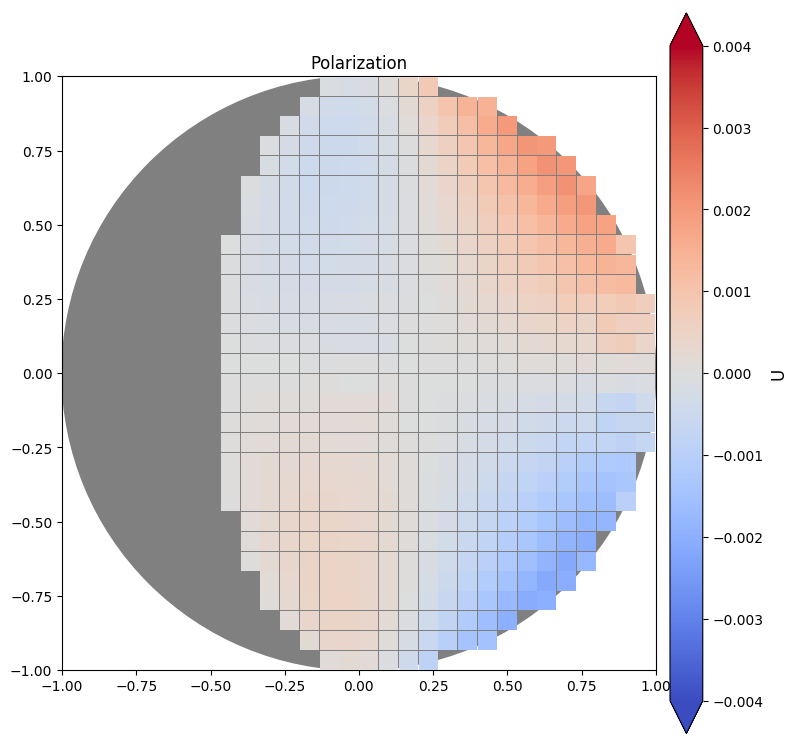

In [44]:
pmd.plot_pixels(model, stokes='U', phase_idx=4, vmin=-0.004, vmax=0.004, cmap='coolwarm')

But `plot_pixels` also allows to display the results in a longitute/latitude map:

(<Figure size 800x800 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcf25cb8898>)

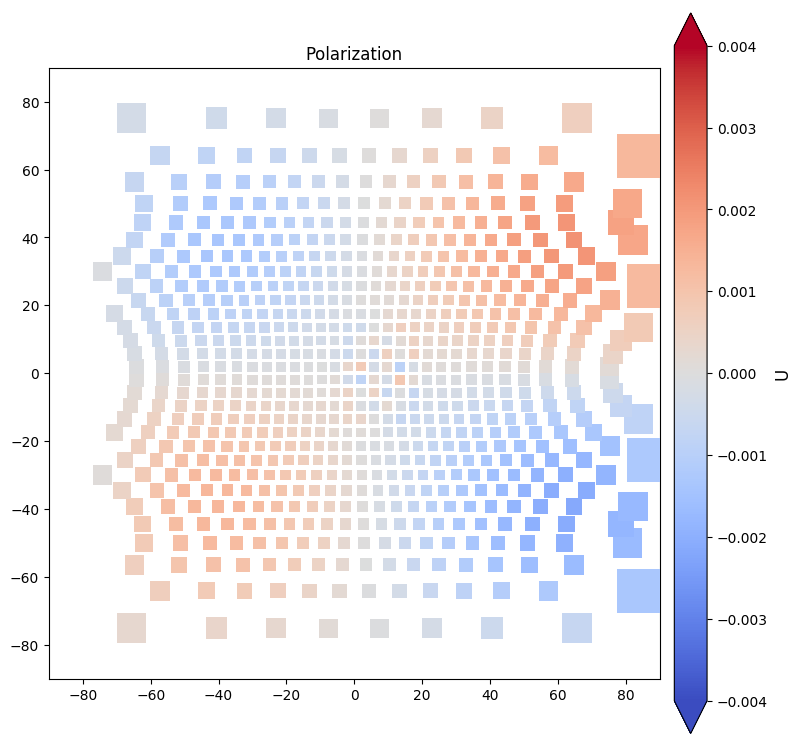

In [45]:
pmd.plot_pixels(model, stokes='U', display='map', phase_idx=0, vmin=-0.004, vmax=0.004, cmap='coolwarm')

But no planet (except maybe Venus in first order) can be modeled by a uniform, homogeneous planet. It it sometimes useful to have inhomogenous planets. Here come other options for the `pmd.planet_pixels`.

First, options to define a mask. This mask will make the distinction between pixels using the main model and pixels using an alternative model. Basically, the mask will be 0 if the first model has to be used, 1 if the second model has to be used, 2 for the third model, etc.

* `cusp`: if `True`, polar cusps are created
* `thresh_lat`: defines the latitude above which the cusps exist
* `patchy`: if `True`, patchy clouds are generated
* `bands`: if `True`, latitudinal bands are generated
* `fclouds`: (a list) fractions of the planet to be covered with clouds. It is automatically normalized to 1 such as [2,3,5] is equivalent to [0.2, 0.3, 0.5]. It is expecting the same length as the list of model given in input.

    **Important**: this is the fraction of the whole planetary disk not just the visible part. So for high phase angles, the real fractions will be lower or higher.

* `constant_fcloud`: if `True`, the factor fcloud applies not to the whole planet but to the lit part of the planet
* `sscloud`: if `True`, a subsolar cloud is created
* `sigma_c`: extend in degrees of the subsolar cloud with respect to the SSP. Cloud exists for SZA\<sigma_c
* `delta_c`: offset in degrees the position of the subsolar cloud with respect to subsolar point.
* `bands_lats`: an array defining the boundaries of the bands. Should start at -90 and end at +90.
* `adaptive_pixels`: if `True`, npix increases with increasing phase angle (in sin^2 of alpha/2)
* `pixscaler`: factor used in combination with adaptive_pixels to set the rate of increase in pix number
* `xscale`: for patchy clouds gives the typical size on x-axis, as a function of npix
* `yscale`: for patchy clouds gives the typical size on y-axis, as a function of npix
* `fixed_pattern`: if `True`, a cloud pattern is generated at start and then reused for all phase angle after.
* `input_pattern`: an existing pattern that can be used (caution: must have size npix\*npix\*nalpha)

When this function is called, the mask generated (if fixed using fixed_pattern) will be put in the model, under the model.picture attribute. So you can compare several models with the same cloud cover using the option `input_pattern=model.picture` in the second run.

In [46]:
pmd.planet_pixels([model,modelB], npix=30, patchy=True, fclouds=[0.7,0.3], alpha=[50, 75], force=True)

In layer gasbelow:
Beginning of Mie program
Wavelength 1.1010000
End of Mie program
Aerosols mixed!
In layer gastop:
Beginning of Mie program
Wavelength 1.1010000
End of Mie program
Aerosols mixed!
In layer cloud:
Beginning of Mie program
Wavelength 1.1010000
End of Mie program
Aerosols mixed!
In layer haze:
Beginning of Mie program
Wavelength 1.1010000
End of Mie program
Aerosols mixed!
Beginning of DAP program
Wavelength 1.1010000 microns
C.sc.1.1010000
C.sc.1.1010000
C.sc.1.1010000
C.sc.1.1010000
fou_1.1010000.dat
End of DAP program
In layer gasbelow:
Beginning of Mie program
Wavelength 1.1010000
End of Mie program
Aerosols mixed!
In layer gastop:
Beginning of Mie program
Wavelength 1.1010000
End of Mie program
Aerosols mixed!
In layer cloud:
Beginning of Mie program
Wavelength 1.1010000
End of Mie program
Aerosols mixed!
In layer haze:
Beginning of Mie program
Wavelength 1.1010000
End of Mie program
Aerosols mixed!
Beginning of DAP program
Wavelength 1.1010000 microns
C.sc.1.101000

/home/loic/Bureau/pymiedap/pymiedap/pymiedap.py:2819: RuntimeWarning: invalid value encountered in greater_equal
  cl = np.where(grid_full>=0)[0].size
/home/loic/Bureau/pymiedap/pymiedap/pymiedap.py:2835: RuntimeWarning: invalid value encountered in greater_equal
  cl = np.where(grid_lit>=0)[0].size


Reading dap_database/modelB_1.1010000.dat
Reading dap_database/modelA_1.1010000.dat
Reading dap_database/modelB_1.1010000.dat


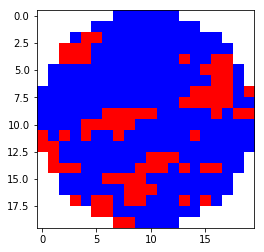

In [76]:
mpl.imshow(model.picture, cmap='bwr')

(<Figure size 800x800 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcf25c7a5f8>)

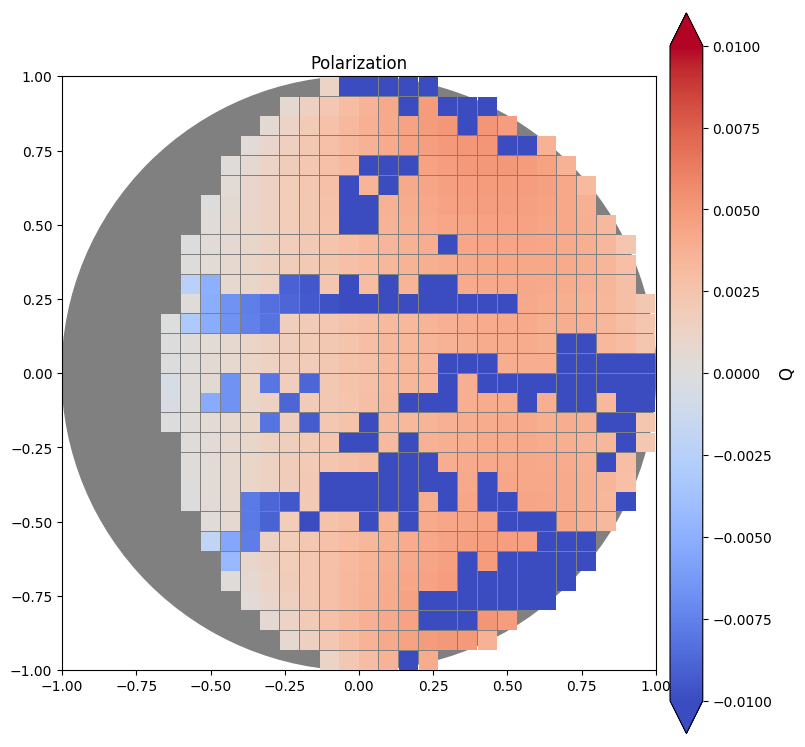

In [48]:
pmd.plot_pixels(model, stokes='Q', phase_idx=0, vmin=-0.01, vmax=0.01, cmap='coolwarm')

Now, we try a subsolar cloud, extending up to $45^\circ$ away from the subsolar point, seen at a phase angle of $50^\circ$

/home/loic/Bureau/pymiedap/pymiedap/pymiedap.py:2835: RuntimeWarning: invalid value encountered in greater_equal
  cl = np.where(grid_lit>=0)[0].size


Reading dap_database/modelA_1.1010000.dat
Reading dap_database/modelB_1.1010000.dat


(<Figure size 800x800 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcf25c19d30>)

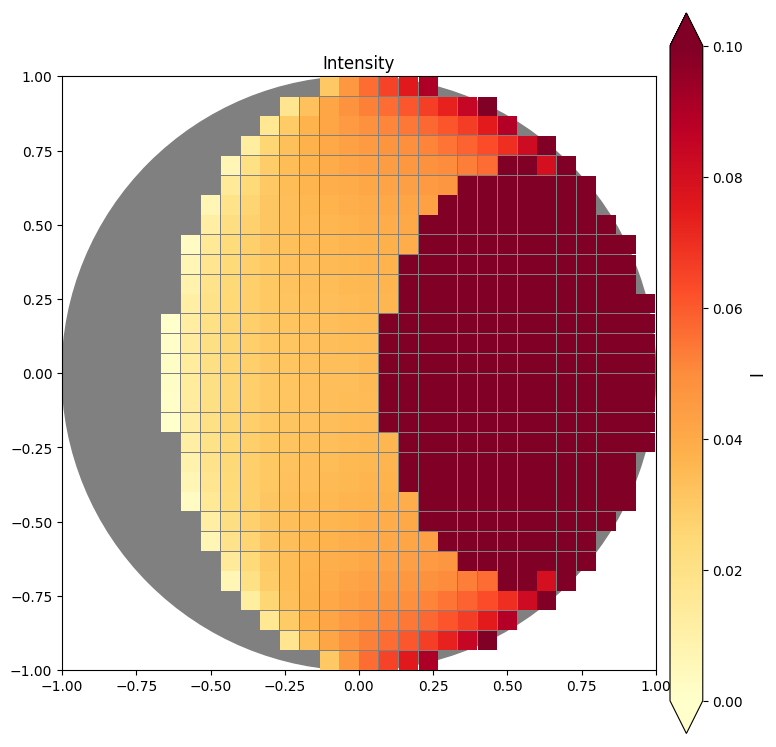

In [49]:
# Other examples of masks
pmd.planet_pixels([model,modelB], npix=30, patchy=False, sscloud=True, sigma_c=45, alpha=[50], force=False)
pmd.plot_pixels(model, stokes='I', phase_idx=0, vmin=0, vmax=0.1, title='Intensity', cmap='YlOrRd')

And now polar clouds extending from $45^\circ$ of latitude, up to the poles.

/home/loic/Bureau/pymiedap/pymiedap/pymiedap.py:2835: RuntimeWarning: invalid value encountered in greater_equal
  cl = np.where(grid_lit>=0)[0].size


Reading dap_database/modelA_1.1010000.dat
Reading dap_database/modelB_1.1010000.dat


(<Figure size 800x800 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcf23b9efd0>)

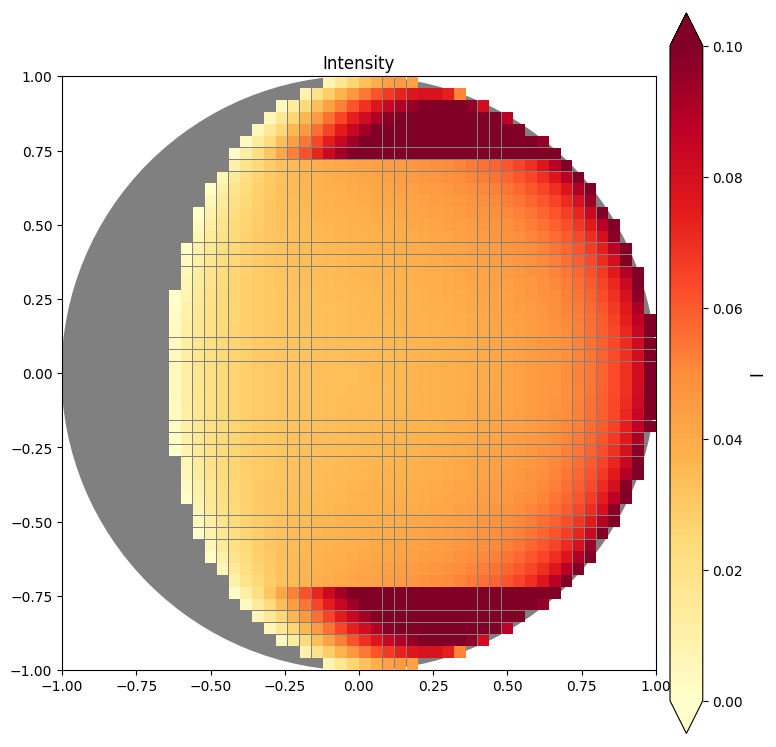

In [50]:
pmd.planet_pixels([model,modelB], npix=50, patchy=False, sscloud=False, cusp=True, thresh_lat=45, alpha=[50], force=False)
pmd.plot_pixels(model, stokes='I', phase_idx=0, vmin=0, vmax=0.1, title='Intensity', cmap='YlOrRd')

And finally, a band distribution, with clouds between $-90^\circ$ and $-45^\circ$ and between $0^\circ$ and $35^\circ$ of latitude.

/home/loic/Bureau/pymiedap/pymiedap/pymiedap.py:2835: RuntimeWarning: invalid value encountered in greater_equal
  cl = np.where(grid_lit>=0)[0].size


Reading dap_database/modelA_1.1010000.dat
Reading dap_database/modelB_1.1010000.dat
Reading dap_database/modelA_1.1010000.dat
Reading dap_database/modelB_1.1010000.dat


(<Figure size 800x800 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcf23b34240>)

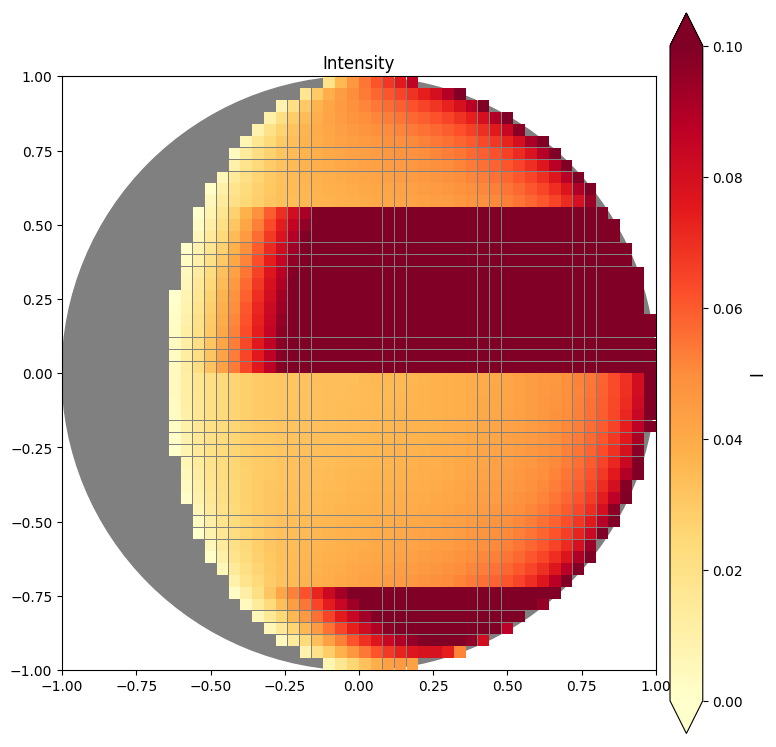

In [51]:
pmd.planet_pixels([model,modelB,model,modelB], npix=50, patchy=False, bands=True, bands_lats=[-90,-45,0,35,90], alpha=[50], force=False, output_names=['A','B','A','B'])
pmd.plot_pixels(model, stokes='I', phase_idx=0, vmin=0, vmax=0.1, title='Intensity', cmap='YlOrRd')

### Disk-integrated case

If you're working with distant objects, in particular exoplanets, you will probably only have the integrated signal. The function pmd.planet_integrated does exactly this.

It turns out that this function has a lot of arguments in common with `pmd.planet_pixels`. The only difference is the output. No pictures this time, but the same classical output within model (see `pmd.read_model`).

Note that the system is assumed to be seen under a 'edge-on' configuration and the planet has no obliquity.

In [52]:
phases = np.linspace(0,150,50) # defining phase angles
pmd.planet_integrated([model,modelB], npix=20, alpha=phases, patchy=True, fclouds=[0.75,0.25]) # this 75% clouds

/home/loic/Bureau/pymiedap/pymiedap/pymiedap.py:2819: RuntimeWarning: invalid value encountered in greater_equal
  cl = np.where(grid_full>=0)[0].size
/home/loic/Bureau/pymiedap/pymiedap/pymiedap.py:2835: RuntimeWarning: invalid value encountered in greater_equal
  cl = np.where(grid_lit>=0)[0].size


Reading dap_database/modelA_1.1010000.dat
Reading dap_database/modelB_1.1010000.dat
2.000000% done
Reading dap_database/modelA_1.1010000.dat
Reading dap_database/modelB_1.1010000.dat
4.000000% done
Reading dap_database/modelA_1.1010000.dat
Reading dap_database/modelB_1.1010000.dat
6.000000% done
Reading dap_database/modelA_1.1010000.dat
Reading dap_database/modelB_1.1010000.dat
8.000000% done
Reading dap_database/modelA_1.1010000.dat
Reading dap_database/modelB_1.1010000.dat
10.000000% done
Reading dap_database/modelA_1.1010000.dat
Reading dap_database/modelB_1.1010000.dat
12.000000% done
Reading dap_database/modelA_1.1010000.dat
Reading dap_database/modelB_1.1010000.dat
14.000000% done
Reading dap_database/modelA_1.1010000.dat
Reading dap_database/modelB_1.1010000.dat
16.000000% done
Reading dap_database/modelA_1.1010000.dat
Reading dap_database/modelB_1.1010000.dat
18.000000% done
Reading dap_database/modelA_1.1010000.dat
Reading dap_database/modelB_1.1010000.dat
20.000000% done
Read

In the above, we give two models that will be used with the mask. Remember that the mask generated will associate value 0 with the first model and 1 to the second, etc. The patches, the subsolar cloud or the polar clouds have a maks value of 0, so they correspond to the first model you give.

`niter` hasn't been covered so far. In the case of patchy clouds, the position of the patches is random, so you'll get only one possible realization. If you want to have an average representation, you can set the number of patterns you want to simulate. Then the code will average these realizations and return the average. 

In [77]:
pmd.planet_integrated([modelB,model], npix=20, alpha=phases, patchy=True, fclouds=[0.75,0.25], niter=50) #this is 25% clouds
# note that model and modelB are swapped.

/home/loic/Bureau/pymiedap/pymiedap/pymiedap.py:2819: RuntimeWarning: invalid value encountered in greater_equal
  cl = np.where(grid_full>=0)[0].size
/home/loic/Bureau/pymiedap/pymiedap/pymiedap.py:2835: RuntimeWarning: invalid value encountered in greater_equal
  cl = np.where(grid_lit>=0)[0].size


Reading dap_database/modelB_1.1010000.dat
Reading dap_database/modelA_1.1010000.dat
2.000000% done
Reading dap_database/modelB_1.1010000.dat
Reading dap_database/modelA_1.1010000.dat
4.000000% done
Reading dap_database/modelB_1.1010000.dat
Reading dap_database/modelA_1.1010000.dat
6.000000% done
Reading dap_database/modelB_1.1010000.dat
Reading dap_database/modelA_1.1010000.dat
8.000000% done
Reading dap_database/modelB_1.1010000.dat
Reading dap_database/modelA_1.1010000.dat
10.000000% done
Reading dap_database/modelB_1.1010000.dat
Reading dap_database/modelA_1.1010000.dat
12.000000% done
Reading dap_database/modelB_1.1010000.dat
Reading dap_database/modelA_1.1010000.dat
14.000000% done
Reading dap_database/modelB_1.1010000.dat
Reading dap_database/modelA_1.1010000.dat
16.000000% done
Reading dap_database/modelB_1.1010000.dat
Reading dap_database/modelA_1.1010000.dat
18.000000% done
Reading dap_database/modelB_1.1010000.dat
Reading dap_database/modelA_1.1010000.dat
20.000000% done
Read

Because we are dealing with a disk integrated simulation, there is only one value of I, Q, U and V for each phase angle. Hence, the shape of the Stokes elements is (number of wavelengths, number of phase angles).

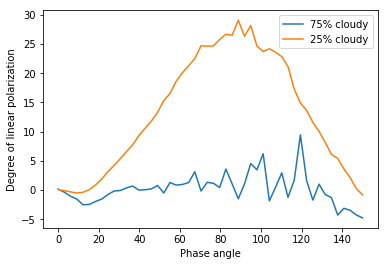

In [78]:
mpl.plot(model.phase,100*model.P[0,:], label='75% cloudy')
mpl.plot(modelB.phase, 100*modelB.P[0,:], label='25% cloudy')
mpl.xlabel('Phase angle')
mpl.ylabel('Degree of linear polarization')
mpl.legend()

For patchy clouds, you also get more statistics stored in the `Model` object. All arrays related to statistics have the same shape as I, Q, U and V. That is (nwvl, nphases, niterations)

* `model.Xstd`: for any variable X, this is the standard deviation over all the realizations. Shape is (nwvl, nphases)
* `model.Xall`: all realizations stored in an array.
* `model.Xmin` and `model.Xmax`: minimal and maximal value over all iterations

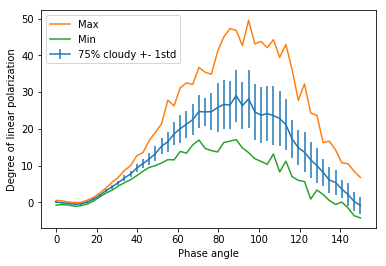

In [79]:
mpl.errorbar(modelB.phase,100*modelB.P[0,:], yerr=100*modelB.Pqstd[0,:], label='75% cloudy +- 1std') #Psstd is the 1sigma variation due to patchiness
mpl.plot(modelB.phase,100*modelB.Pqmax[0,:], label='Max')
mpl.plot(modelB.phase,100*modelB.Pqmin[0,:], label='Min')
mpl.xlabel('Phase angle')
mpl.ylabel('Degree of linear polarization')
mpl.legend(loc='upper left')

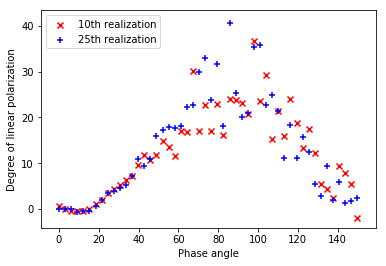

In [80]:
mpl.scatter(modelB.phase,100*modelB.Pqall[0,:,10], c='r', marker='x', label='10th realization')
mpl.scatter(modelB.phase,100*modelB.Pqall[0,:,25], c='b', marker='+', label='25th realization')

mpl.xlabel('Phase angle')
mpl.ylabel('Degree of linear polarization')
mpl.legend(loc='upper left')

### Other outputs

This function will also update other outputs in the model:

* `fcloud`: a vector with the cloud cover for each phase angle when doing resolved and integrated simulations
* `asym`: asymmetry in cloud cover, for each phase angle and for each iteration. That is to say, the fraction of pixels in the northern hemisphere which have corresponding mask value in the southern hemisphere. If only the northern hemisphere is cloudy, `asym` will be equal to 1. A planet with a checkboard pattern would also have `asym=1`. If the planet is homogeneous, `asym=0`.



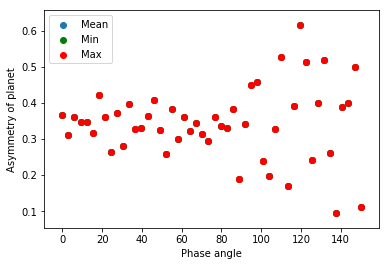

In [84]:
mpl.scatter(model.phase,np.nanmean(model.asym,axis=1), label='Mean')
mpl.scatter(model.phase,np.nanmin(model.asym,axis=1), c='g', label='Min')
mpl.scatter(model.phase,np.nanmax(model.asym,axis=1), c='r', label='Max')
mpl.xlabel('Phase angle')
mpl.ylabel('Asymmetry of planet')
mpl.legend(loc='upper left')

This is it for this tutorial. If you want to have details about specific functions, the inline documentation is here to help.

This code is open to evolutions, so do not hesitate to send suggestions for new functions or bug reports!